## HubMap Training Notebook

### Setup

In [23]:
import os
import gc
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

### Config

In [24]:
class CFG:
    LR = 3e-5
    EPOCHS = 100
    BATCH_SIZE = 8
    N_TRAIN = 1400 # Take first N_TRAIN images for training, rest for validation
    
    device = 'cpu' #  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataloaders

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from PIL import Image
from skimage.draw import polygon
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, BboxParams



class HubmapDataset(Dataset):
        
    def __init__(self, image_dir, labels_file, n_train, mode='train'):
        
        assert mode in ['train', 'val'], "mode must be one of ['train', 'val']"
        self.mode = mode
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]

        if mode == 'train':
            self.json_labels = self.json_labels[:n_train]
        else:
            self.json_labels = self.json_labels[n_train:]

        self.image_dir = image_dir
        
        
        if mode == 'train':
            initial_augm = [
            
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.1),
                A.CoarseDropout(max_holes=1, max_width=int(512 * 0.05), max_height=int(512 * 0.05), 
                                mask_fill_value=0, p=0.1),
                
                
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.1),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
            ]
        else:
            initial_augm = []
        
        self.aug_list = initial_augm + [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.aug_list)

    def __len__(self):
        return len(self.json_labels)
        
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)
        
        
        # Get the mask
        mask = np.zeros((512, 512), dtype=np.float32)
        
        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cord in cords:
                    rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                    mask[rr, cc] = 1
                    
        image = np.array(image)

        # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        # mask = torch.tensor(mask, dtype=torch.float32)


        augmented = self.augmentations(image=image, mask=mask)
        image, mask = augmented["image"], augmented["mask"]
        
        
        
        return image, mask


In [26]:
train_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='train')

val_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='val')

In [27]:
from transformers import SegformerForSemanticSegmentation
import torch
from collections import OrderedDict

class Segformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=1,
                                                         ignore_mismatched_sizes=True,
                                                         num_channels=3)
        self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
    def forward(self, x):
        x = self.seg_model(x).logits
        x = self.up(x)
        return x



model = Segformer()
state_dict = torch.load("ckpts/segformer_epoch_31.pt")
model.load_state_dict(state_dict)
model = model.to(CFG.device)

# set model to eval mode
model.eval();

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head

In [28]:
x = torch.randn(1, 3, 512, 512).to(CFG.device)
with torch.no_grad():
    out = model(x)

out.shape

torch.Size([1, 1, 512, 512])

torch.Size([3, 512, 512])


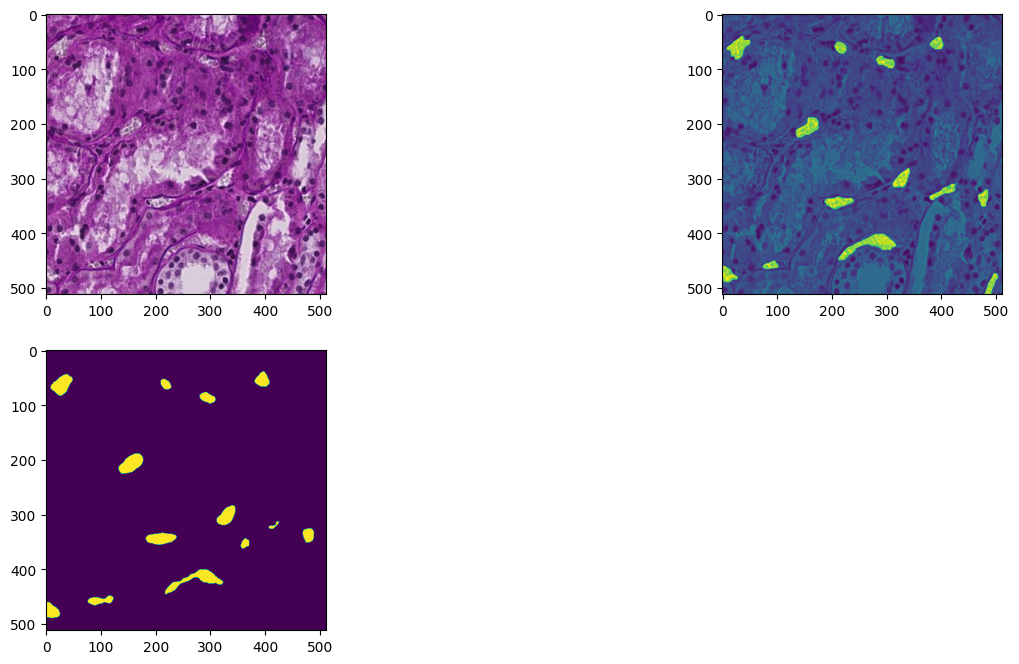

In [50]:
# visualize the data

indx = np.random.randint(0, len(val_dataset))
image, mask = val_dataset[indx]
print(image.shape)

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.imshow(image.permute(1, 2, 0))

plt.subplot(2, 2, 2)
plt.imshow(0.5 * image.permute(1, 2, 0)[:, :, 0] + 0.6 * mask)

# visualize the prediction
plt.subplot(2, 2, 3)
mask_pred = model(image.unsqueeze(0).to(CFG.device)).squeeze().detach().cpu().numpy()
mask_pred = (mask_pred > 0.5).astype(np.float32)
plt.imshow(mask_pred)
